# Novel Views from existing Nerfacto model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/nerfstudio

/home/nerfstudio


In [3]:
from scripts.render import RenderTrajectory
from pathlib import Path
import json

#### Utils

In [4]:
import ipywidgets as widgets
import json

def generate_dropdown(values, selected=0, description=''):
    dd = widgets.Dropdown(
        options=values,
        value=values[selected],
        description=description,
        disabled=False,
    );
    
    display(dd)
    
    return dd

def generate_slider(minimum, maximum, description=''):
    s = widgets.FloatSlider(
        value=(maximum - minimum) / 2,
        min=minimum,
        max=maximum,
        step=0.1,
        description=description,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
    
    display(s)
    
    return s


def update_json(path, field, value):
    js = json.loads(path.read_text())

    js[field] = value

    with path.open(mode='w') as f:
        f.write(json.dumps(js))
        
def update_json_resolution(path, width, height):
    update_json(path, 'render_height', int(height))
    update_json(path, 'render_width', int(width))
    
def update_json_camera_path(path, index, value):
    js = json.loads(path.read_text())
    
    js['camera_path'][0]['camera_to_world'][index] = value
    
    with path.open(mode='w') as f:
        f.write(json.dumps(js))
        
def generate_image(index=None, value=None):
    if index:
        update_json_camera_path(camera_path_filename, index, value)
    else:
        !cp colab/camera_path_short_bak.json colab/camera_path_short.json
    rt = RenderTrajectory(
        load_config=load_config, 
        traj='filename', 
        camera_path_filename=camera_path_filename,
        output_format='images' # change to video to generate mp4
    )
    rt.main()
    
def render_trajectory(camera_path_filename):
    rt = RenderTrajectory(
        load_config=load_config,
        traj='filename', 
        camera_path_filename=camera_path_filename,
        output_format='images' # change to video to generate mp4
    )
    rt.main()

## Getting back the images

In [5]:
# trained model definition
load_config = Path('outputs/poster/nerfacto/2023-03-07_140755/config.yml')
# camera_path_filename = Path('colab/camera_path.json') # ~100 frames

# camera path
camera_path_filename = Path('colab/camera_path_short.json') # 1 frame

In [6]:
dd = generate_dropdown(['100x70', '1920x1080', '4096x2160'], 0, 'Resolution:')
s = generate_slider(0, 1.0, "Up/Down?")

Dropdown(description='Resolution:', options=('100x70', '1920x1080', '4096x2160'), value='100x70')

FloatSlider(value=0.5, continuous_update=False, description='Up/Down?', max=1.0, readout_format='.1f')

In [7]:
!cp colab/camera_path_short_bak.json colab/camera_path_short.json
width, height = dd.value.split('x')
update_json_resolution(camera_path_filename, width, height) # set resolution for the output image

generate_image(11, s.value) # camera_path[0][camera_to_world][11] is up/down?

[09:31:24] Auto image downscale factor of 2                                                 ]8;id=294241;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=858604;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#314\314]8;;\

           Skipping 0 files in dataset split train.                                         ]8;id=436925;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=516405;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#165\165]8;;\

           Skipping 0 files in dataset split test.                                          ]8;id=532106;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=783978;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#165\165]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/poster/nerfacto/2023-03-07_140755/nerfstudio_models/step-000029999.ckpt

Creating trajectory images

Output()

## Getting back samples along the rays

see 

In [208]:
from scripts.render_raw import RenderTrajectory as RenderTrajectoryRaw

rt = RenderTrajectoryRaw(
    load_config=load_config,
    traj='filename', 
    camera_path_filename=camera_path_filename,
    output_format='images' # change to video to generate mp4
)
raws = rt.main()

[11:14:53] Auto image downscale factor of 2                                                 ]8;id=436255;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=236148;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#314\314]8;;\

           Skipping 0 files in dataset split train.                                         ]8;id=403854;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=632968;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#165\165]8;;\

           Skipping 0 files in dataset split test.                                          ]8;id=565750;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=60068;file:///home/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#165\165]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/poster/nerfacto/2023-03-07_140755/nerfstudio_models/step-000029999.ckpt

Creating trajectory 


Output()

In [209]:
raws.keys()

dict_keys(['rgb', 'accumulation', 'depth', 'samples_rgb', 'samples_density', 'samples_weights', 'ray_samples_frustums_origins', 'ray_samples_frustums_directions', 'ray_samples_frustums_ends', 'prop_depth_0', 'prop_depth_1'])

tensors in nerfstudio are shaped for presentation as images and they need to be reshaped  back to original shape

In [210]:
for key in raws.keys():
    if 'samples' in key:
        print(key)
        raws[key] = raws[key].view(int(height), int(width), 48, -1)

samples_rgb
samples_density
samples_weights
ray_samples_frustums_origins
ray_samples_frustums_directions
ray_samples_frustums_ends


#### Render image

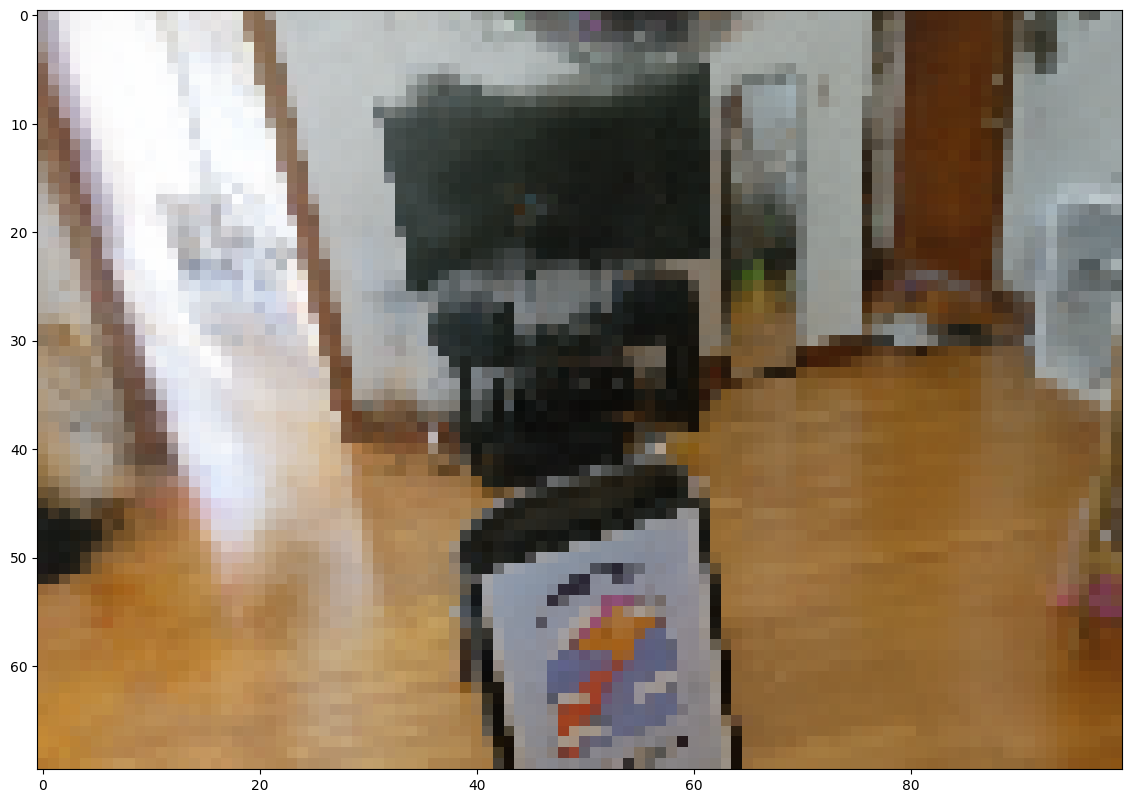

In [211]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 20))
plt.imshow(raws['rgb'])

#### Render samples with sample weights

Weights is density predicted by the `Field` put through `ray_samples.get_weights()`

In [212]:
def show_samples_at(h, w):
    plt.imshow(
        (raws['samples_weights'][h, w])[None,] /
        raws['samples_weights'][h, w].sum()
    ,cmap='Greys')
    plt.title(f'Weights @ ({h},{w})')
    plt.show()
    plt.imshow(
        (raws['samples_rgb'][h,w]*255).int()[None,]
    )
    plt.title(f'Colour @ ({h},{w})')
    plt.xlabel('sample depth')
    plt.show()

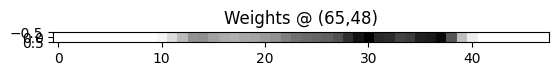

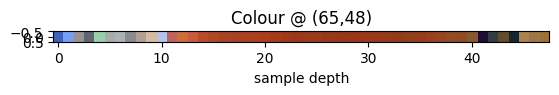

In [213]:
# red patch on a poster
show_samples_at(65, 48)

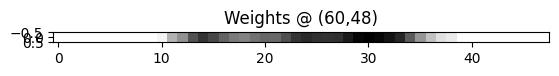

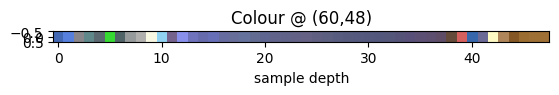

In [214]:
# Blue patch on a poster
show_samples_at(60, 48)

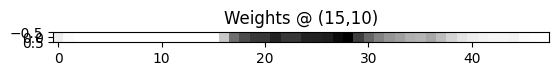

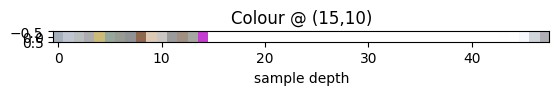

In [215]:
# Window
show_samples_at(15, 10)

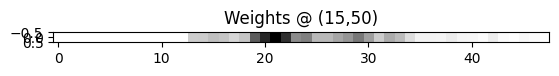

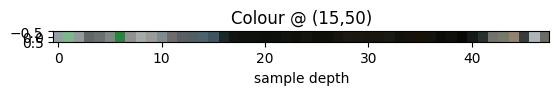

In [216]:
# TV
show_samples_at(15, 50)

#### Render image from samples

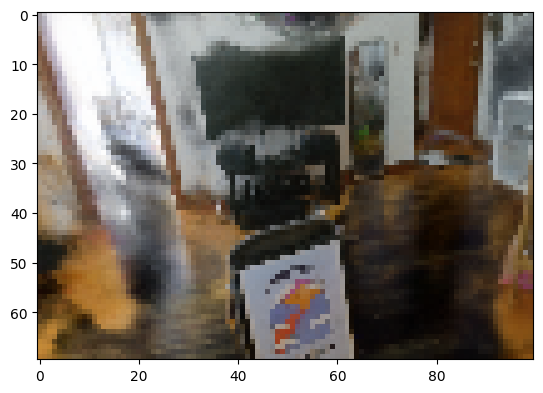

In [207]:
plt.imshow(
    ((raws['samples_rgb'] * raws['samples_weights'])).sum(dim=2)
)

#### Generate images for each index in camera_to_world

In [10]:
# for index in range(12):
#     for value in range(0, 31, 10):
#         !cp colab/camera_path_short_bak.json colab/camera_path_short.json
#         generate_image(index, float(value)/10)
#         !mv renders/output/00000.png renders/output/file_{index}_{value}.png

In [178]:
raws['samples_weights'].shape, raws['samples_rgb'].shape

(torch.Size([70, 100, 48]), torch.Size([70, 100, 144]))